In [1]:
# Create a toy dataset for a sparse reward RL environment, and traing a preference learning model for it
# Created by Alexander Li, 2023-12-07

import numpy as np
import matplotlib.pyplot as plt
import os

# Function to get the next available filename
def get_next_filename(base_name, extension):
    index = 1
    while True:
        filename = f"{base_name}_{index}.{extension}"
        if not os.path.exists(filename):
            return filename
        index += 1


# The environment is a 1D line from -2.0 to 2.0, with a goal at location 1.0, and a grid size of 0.01
# The agent starts at a random location, with the option to move left or right by 0.01, and a slight bias to move towards the goal
# The reward is 1.0 if the agent reaches the goal, and 0.0 otherwise 
# The agent is terminated after 3000 steps

# create a dataset of 1000 trajectories of 3000 steps each as a 1D vector
goal_location = 1.0
goal_threshold = 0.05
world_size = 2.0
grid_size = 0.01
step_size = 0.01
direction_bias = 0.1
n_eps = 1000
eps_length = 3000


In [2]:
# create a dataset, dtype is object so that each element can be a different length
dataset = []
# for every episode
for i in range(n_eps):
    # add a new trajectory
    trajectory = []
    # start at a random location
    start_location = np.random.uniform(-world_size, world_size)
    # round to the nearest grid point
    start_location = np.round(start_location / grid_size) * grid_size
    # append a tuple of the time, start location, and reward)
    trajectory.append((0, start_location, 0.0))

    # for every time step
    for j in range(1, eps_length):
        # old location
        old_location = trajectory[j-1][1]
        
        # add a slight bias to move towards the goal
        if np.random.uniform() < direction_bias:
            # if the agent is to the left of the goal, move right
            if old_location < goal_location:
                new_location = old_location + step_size
            # if the agent is to the right of the goal, move left
            else:
                new_location = old_location - step_size
        else:
            # move left or right by the step size
            new_location = old_location + np.random.choice([-step_size, step_size])

        # terminate if the agent reaches the goal within a threshold
        if np.abs(new_location - goal_location) < goal_threshold:
            trajectory.append((j, new_location, 1.0))
            trajectory = np.array(trajectory, dtype=object)
            # append trajectory to dataset
            dataset.append(trajectory)
            break
        else:
            # append tuple of time, location, and reward
            trajectory.append((j, new_location, 0.0))
dataset = np.array(dataset, dtype=object)

In [3]:
print("The length of the dataset is: " + str(len(dataset)))
print("The length of the first trajectory is: " + str(len(dataset[0])))
print(dataset[0])

The length of the dataset is: 955
The length of the first trajectory is: 360
[[0 1.52 0.0]
 [1 1.53 0.0]
 [2 1.52 0.0]
 ...
 [357 1.0699999999999996 0.0]
 [358 1.0599999999999996 0.0]
 [359 1.0499999999999996 1.0]]


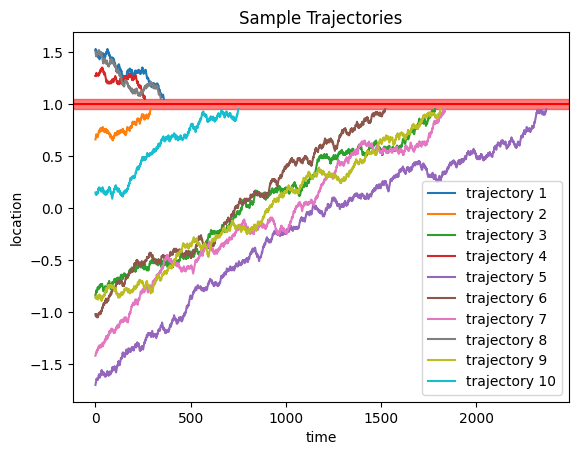

In [6]:
# plot 5 sample trajectories on the same plot, including the goal line
plt.axhline(y=goal_location, color='r', linestyle='-')
# include the error region
plt.axhspan(goal_location - goal_threshold, goal_location + goal_threshold, alpha=0.5, color='r')
# plot the 5 trajectories
for i in range(10):
    plt.plot([x[0] for x in dataset[i]], [x[1] for x in dataset[i]], label=f"trajectory {i+1}")
plt.xlabel('time')
plt.ylabel('location')
plt.title('Sample Trajectories')
plt.legend()
base_filename = 'figs/sample_trajectories'
file_extension = 'png'
next_filename = get_next_filename(base_filename, file_extension)
plt.savefig(next_filename)
plt.show()


In [7]:
import torch

# create a preference dataset from the trajectories
# one tensor for sampling 2 states, one tensor for the preference
# the preference is 1 if the time of the first state is closer to the goal than the time of the second state
# the preference is 0 if the time of the second state is closer to the goal than the time of the first state
# number of samples 
n_samples = 100000
state_pairs = torch.zeros((n_samples, 2))
preferences = torch.zeros((n_samples, 1))
preference_slack = 100
for i in range(n_samples):
    # randomly select an episode
    episode = np.random.choice(dataset)
    # randomly generate 2 indices from that episode
    idx1, idx2 = np.random.choice(len(episode), 2)
    # randomly select two states from that episode
    state1, state2 = episode[idx1], episode[idx2]
    # extract the time and location of each state
    t1, t2 = state1[0], state2[0]
    x1, x2 = state1[1], state2[1]
    t_goal = episode[-1][0]
    ttg1 = t_goal - t1
    ttg2 = t_goal - t2
    # assign the states to the tensor
    state_pairs[i, 0] = x1
    state_pairs[i, 1] = x2
    # if the states are within a neighbourhood:
    if np.abs(t1 - t2) <= preference_slack:
        preferences[i, 0] = 0.5
    # else if the first state is closer to the goal
    elif ttg1 < ttg2:
        preferences[i, 0] = 1.0
    # if the second state is closer to the goal
    else:
        preferences[i, 0] = 0.0

The shape of the state pairs are: 
torch.Size([100000, 2])
The state pairs are: tensor([[0.5200, 0.4000],
        [0.3600, 0.4100],
        [1.1700, 1.3100],
        ...,
        [0.8700, 0.8500],
        [0.8400, 0.8700],
        [0.3100, 0.7100]])

The shape of the preferences are: 
torch.Size([100000, 1])
The preferences are: tensor([[1.0000],
        [0.5000],
        [1.0000],
        ...,
        [0.0000],
        [0.5000],
        [0.0000]])


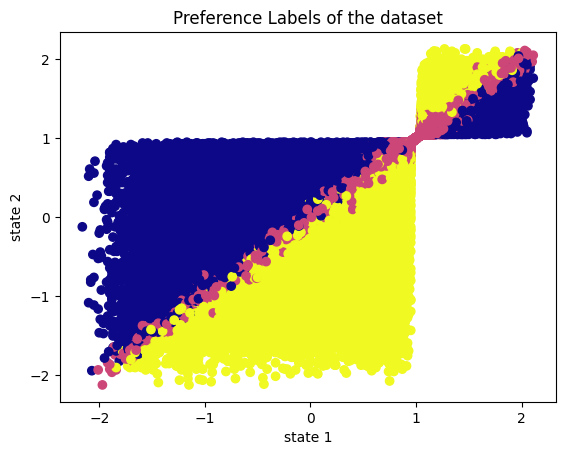

In [9]:
print("The shape of the state pairs are: \n" + str(state_pairs.size()))
print("The state pairs are: " + str(state_pairs))
print("")
print("The shape of the preferences are: \n" + str(preferences.size()))
print("The preferences are: " + str(preferences))

# visualise the dataset
plt.scatter(state_pairs[:, 0], state_pairs[:, 1], c=preferences[:, 0], cmap="plasma")
plt.xlabel('state 1')
plt.ylabel('state 2')
plt.title('Preference Labels of the dataset')
base_filename = 'figs/preference_labels'
file_extension = 'png'
next_filename = get_next_filename(base_filename, file_extension)
plt.savefig(next_filename)
plt.show()

In [10]:
# turn the dataset into a dataloader
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

class PreferenceDataset(Dataset):
    def __init__(self, state_pairs, preferences):
        self.state_pairs = state_pairs
        self.preferences = preferences

    def __getitem__(self, index):
        return self.state_pairs[index], self.preferences[index]

    def __len__(self):
        return len(self.state_pairs)

In [11]:
dataset = PreferenceDataset(state_pairs, preferences)
# split the dataset into train, validation and test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
# create dataloaders
batch_size = 200
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

# print the shapes of batches from dataloaders
batch = next(iter(train_loader))
print("The shape of the input batch: " + str(batch[0].shape))
print("The shape of the batch labels: " + str(batch[1].shape))

The shape of the input batch: torch.Size([200, 2])
The shape of the batch labels: torch.Size([200, 1])


In [12]:
import torch.nn as nn

# create a preference learning model
class PreferenceModel(nn.Module):
    def __init__(self):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # apply the linear layers to each state in the state pair
        x1 = self.relu(self.fc1(x[:, 0].unsqueeze(1)))
        x1 = self.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        # split the output as 2 values, one as the predicted reward, the other as the uncertainty in the predicted reward
        u1 = x1[:, 0].unsqueeze(1)
        #s1 = torch.abs(x1[:, 1].unsqueeze(1)) # make the standard deviation always positive
        # repeat for state 2
        x2 = self.relu(self.fc1(x[:, 1].unsqueeze(1)))
        x2 = self.relu(self.fc2(x2))
        x2 = self.fc3(x2)
        # split the output as 2 values, one as the predicted reward, the other as the uncertainty in the predicted reward
        u2 = x2[:, 0].unsqueeze(1)
        #s2 = torch.abs(x2[:, 1].unsqueeze(1)) # make the standard deviation always positive
        # sample a reward from a normal distribution with the predicted reward and uncertainty
        #r1 = torch.normal(u1, s1)
        #r2 = torch.normal(u2, s2)
        # return the sampled preference
        return self.sigmoid(u1 - u2)
    
    def predict_reward(self, x):
        r = self.relu(self.fc1(x[:, 0].unsqueeze(1)))
        r = self.relu(self.fc2(r))
        r = self.fc3(r)
        return r


In [14]:
import torch.nn.functional as F
import torch.optim

# training step
def training_step(input_batch, target_batch, model, optimizer, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    optimizer.zero_grad() # clear gradients in the optimiser
    loss.backward() # back prop
    optimizer.step() # gradient descend
    return loss.item() # return loss

# validation step
def validation_step(input_batch, target_batch, model, loss_fn):
    preds = model(input_batch) # forward pass
    loss = loss_fn(preds, target_batch) # find loss
    return loss.item()


In [15]:
# instantiate
model = PreferenceModel()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def loss_fn(preds, target):
    return F.binary_cross_entropy(preds, target)

num_epochs = 100

In [16]:
base_filename = 'models/best_model'
file_extension = 'pt'
next_filename = get_next_filename(base_filename, file_extension)

# train
train_losses = []
val_losses = []
min_val_loss = float('inf')
early_stop_counter = 0
patience = 10

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    
    # training
    model.train()
    for input_batch, target_batch in train_loader:
        train_loss += training_step(input_batch, target_batch, model, optimizer, loss_fn)
    # validation
    model.eval()
    for input_batch, target_batch in val_loader:
        val_loss += validation_step(input_batch, target_batch, model, loss_fn)
        
    # normalise the losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    
    # Check if validation loss has decreased
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        # Save the model state
        torch.save(model.state_dict(), next_filename)
        # clear early stop counter
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # append the losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # print the losses every 10 epoch
    #if epoch % 10 == 0:
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch: 1/100, Train Loss: 0.5683, Val Loss: 0.5100
Epoch: 2/100, Train Loss: 0.4794, Val Loss: 0.4320
Epoch: 3/100, Train Loss: 0.3787, Val Loss: 0.3521
Epoch: 4/100, Train Loss: 0.3415, Val Loss: 0.3419
Epoch: 5/100, Train Loss: 0.3367, Val Loss: 0.3402
Epoch: 6/100, Train Loss: 0.3358, Val Loss: 0.3398
Epoch: 7/100, Train Loss: 0.3355, Val Loss: 0.3397
Epoch: 8/100, Train Loss: 0.3354, Val Loss: 0.3397
Epoch: 9/100, Train Loss: 0.3353, Val Loss: 0.3396
Epoch: 10/100, Train Loss: 0.3352, Val Loss: 0.3395
Epoch: 11/100, Train Loss: 0.3352, Val Loss: 0.3395
Epoch: 12/100, Train Loss: 0.3351, Val Loss: 0.3395
Epoch: 13/100, Train Loss: 0.3351, Val Loss: 0.3395
Epoch: 14/100, Train Loss: 0.3351, Val Loss: 0.3395
Epoch: 15/100, Train Loss: 0.3351, Val Loss: 0.3395
Epoch: 16/100, Train Loss: 0.3350, Val Loss: 0.3395
Epoch: 17/100, Train Loss: 0.3351, Val Loss: 0.3394
Epoch: 18/100, Train Loss: 0.3351, Val Loss: 0.3394
Epoch: 19/100, Train Loss: 0.3350, Val Loss: 0.3395
Epoch: 20/100, Train 

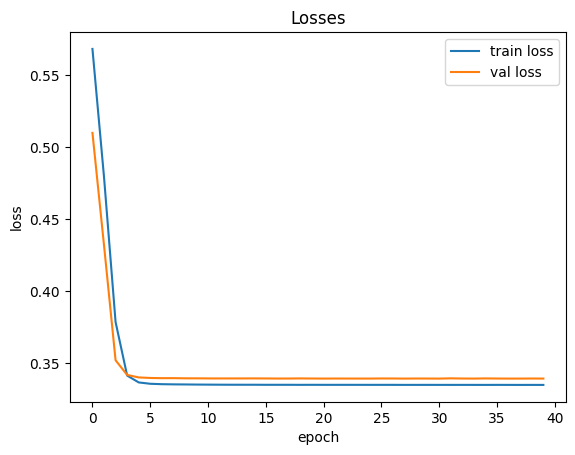

In [17]:
base_filename = 'figs/loss'
file_extension = 'png'
next_filename = get_next_filename(base_filename, file_extension)

# plot the losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')  
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()
plt.savefig(next_filename)
plt.show()

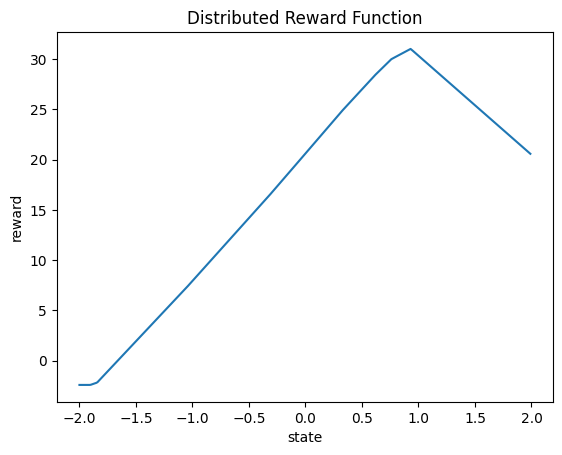

In [18]:
# visualise the reward function
# create a batch of tensor of states from -2.0 to 2.0 with a step size of 0.01
# only use the linear layers of the model to find the reward tensor
# then plot the reward tensor
states = torch.arange(-2.0, 2.0, 0.01).unsqueeze(1)
rewards = model.predict_reward(states)

states = states[:, 0].detach().numpy()
rewards = rewards[:, 0].detach().numpy()
base_filename = 'figs/reward'
file_extension = 'png'
next_filename = get_next_filename(base_filename, file_extension)
plt.plot(states, rewards)
plt.xlabel('state')
plt.ylabel('reward')
plt.title('Distributed Reward Function')
plt.savefig(next_filename)
plt.show()